In [3]:
import numpy as np
import sys
from scipy import signal
from PIL import Image ,ImageOps
import time
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
import pandas as pd
from skimage import io
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import Parameter
import matplotlib.pyplot as plt

def Perona_Malik(img, n, l, k, diff):
    """
    Arg:
        img   - input image
        n     - number of iterations
        k - diffusion coefficient
        l     - stability constant ( 0 <= l <= 0.25)
        diff  - diffusion coefficient 
        
    Output:
        imgout - filtered image
    """
    
    img_ =np.array(img)
    img_ = img_.astype('float32')
    imgout = img_.copy()
    deltaI_NS = np.zeros_like(imgout)
    deltaI_WE = np.zeros_like(imgout)
    NS = np.zeros_like(imgout)
    WE = np.zeros_like(imgout)
    cNS = np.ones_like(imgout)
    cWE = np.ones_like(imgout)
    
    for i in range(n):
        deltaI_NS[:-1,: ] = np.diff(imgout,axis=0)
        deltaI_WE[: ,:-1] = np.diff(imgout,axis=1)
        
        if(diff == 0):
            cNS = np.exp(-(deltaI_NS/k)**2.)
            cWE = np.exp(-(deltaI_WE/k)**2.)
        if(diff == 1):
            cNS = 1./(1.+(deltaI_NS/k)**2.)
            cWE = 1./(1.+(deltaI_WE/k)**2.)
            
            
        NS = cNS*deltaI_NS
        WE = cWE*deltaI_WE
        

        NS[1:,:] -= NS[:-1,:]
        WE[:,1:] -= WE[:,:-1]
 
        imgout = imgout + (l*(NS+WE))
    return (imgout)

def Perona_Malik_torch(img, n, l, k, diff):
    """
    Arg:
        img   - input image
        n     - number of iterations
        coeff - diffusion coefficient
        l     - stability constant ( 0 <= l <= 0.25)
        diff  - diffusion coefficient 
        
    Output:
        imgout - filtered image
    """
    #print(img.shape)
    #tf = transforms.ToTensor()
    #img_ =tf(img)
    #img_ = img_.astype('float32')
    imgout = torch.clone(img)
    #print(imgout.shape)
    #print(img_.shape)
    deltaI_NS = torch.zeros_like(imgout)
    deltaI_WE = torch.zeros_like(imgout)
    NS = torch.zeros_like(imgout)
    WE = torch.zeros_like(imgout)
    cNS = torch.ones_like(imgout)
    cWE = torch.ones_like(imgout)
    #print(NS.shape)
    #print(WE.shape)
    for i in range(n):
        deltaI_NS[:-1,: ] = imgout[1:,:] - imgout[:-1,:]
        deltaI_WE[: ,:-1] = imgout[:,1:] - imgout[:,:-1]
        
        if(diff == 0):
            cNS = torch.exp(-(deltaI_NS/k)**2.)
            cWE = torch.exp(-(deltaI_WE/k)**2.)
        if(diff == 1):
            cNS = 1./(1.+(deltaI_NS/k)**2.)
            cWE = 1./(1.+(deltaI_WE/k)**2.)
            
        
        NS = cNS*deltaI_NS
        WE = cWE*deltaI_WE
        
        NS_ = NS.clone()
        WE_ = WE.clone()
        NS[1:,:] -= NS_[:-1,:]
        WE[:,1:] -= WE_[:,:-1]
 
        imgout = imgout + (l*(NS+WE))
    
    #print(imgout.shape)
    return (imgout)

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros_like(image)
    thres = 1 - prob 
    width, height = image.size
    for i in range(height):
        for j in range(width):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image.getpixel((j,i))
    return Image.fromarray(output)    

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        #torch.manual_seed(14638)
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
def make_operator(name, in_channels=1, out_channels=1, requires_grad=False):
    """create a gradient operator for edge detection and image regularization tasks
    :param name: laplace, scharr_x, or scharr_y
    :param in_channels: e.g. 3 for an RGB image
    :param out_channels: usually the same as the # input channels
    :param requires_grad: learnable operator
    :return: convolutional kernel initialized with one of the operator values
    """
    dtype = Variable
    if requires_grad:
        dtype = Parameter
    operator = get_np_operator(name, in_channels, out_channels)
    return dtype(torch.from_numpy(operator), requires_grad=requires_grad)

def scalar_to_parameter(value, size, requires_grad=False, dtype=torch.FloatTensor):
    return Parameter(dtype([value]).cuda(), requires_grad=requires_grad).expand(size)

def get_np_operator(name, in_channels, out_channels):
    if name == 'laplace':
        return np.array([[[[0.0, 1.0, 0.0]
                         , [1.0, -4.0, 1.0]
                         , [0.0, 1.0, 0.0]]]
                         * in_channels] * out_channels)
    if name == 'scharr_x':
        return np.array([[[[3.0, 0.0, -3.0]
                         , [10.0, 0.0, -10.0]
                         , [3.0, 0.0, -3.0]]]
                         * in_channels] * out_channels)
    if name == 'scharr_y':
        return np.array([[[[3.0, 10.0, 3.0]
                         , [0.0, 0.0, 0.0]
                         , [-3.0, -10.0, -3.0]]]
                         * in_channels] * out_channels)
    raise Exception("Name %s not found"%name)
    
def cuda_cast(param, dtype='float'):
    return getattr(param.cuda(), dtype)()

In [6]:



class BSDSDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file, root_dir , transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.TT = transforms.ToTensor()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image_ = self.transform(image.copy())
        image = self.TT(image.copy())
        return(image_,image)
    
class Aniso_MLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(1,3)
        #self.laplace = make_operator('laplace', requires_grad=True)
        self.scharr_x = make_operator('scharr_x')
        self.scharr_y = make_operator('scharr_y')
        """self.layers = nn.Sequential(
        nn.Conv2d(),
        
        )"""
        self.layers = nn.Sequential(
        nn.Linear(481*321, 77201),
        nn.ReLU(),
        #nn.Linear(256,64),
        #nn.ReLU(),
        #nn.Linear(64,16),
        #nn.ReLU(),
        #nn.Linear(32,4),
        #nn.ReLU(),
        #nn.Linear(8,4),
        #nn.ReLU(),
        nn.Linear(77201,1)
        )
        
    def forward(self, x):
        z = self.flatten(x)
        print(x.shape)
        k = self.layers(z)
        L = Parameter(x)
        L_ = L.unsqueeze(0).repeat(11,1,1,1,1)
        for i in range(L_.shape[2]):
            deltaI_NS = torch.zeros_like(L_[0,i])
            deltaI_WE = torch.zeros_like(L_[0,i])
            NS = torch.zeros_like(L_[0,i])
            WE = torch.zeros_like(L_[0,i])
            cNS = torch.ones_like(L_[0,i])
            cWE = torch.ones_like(L_[0,i])
            
            for j in range(1):
                deltaI_NS[:-1,: ] = L_[j,i][1:,:] - L_[j,i][:-1,:]
                deltaI_WE[: ,:-1] = L_[j,i][:,1:] - L_[j,i][:,:-1]

                #if(diff == 0):
                cNS = torch.exp(-(deltaI_NS/k[i])**2.)
                cWE = torch.exp(-(deltaI_WE/k[i])**2.)
                    #if(diff == 1):
                    #    cNS = 1./(1.+(deltaI_NS/k)**2.)
                    #    cWE = 1./(1.+(deltaI_WE/k)**2.)


                NS = cNS*deltaI_NS
                WE = cWE*deltaI_WE

                NS_ = NS.clone()
                WE_ = WE.clone()
                NS[1:,:] -= NS_[:-1,:]
                WE[:,1:] -= WE_[:,:-1]
                #print(L[i].shape
                #print((L[i]+ 0.2*(NS+WE)).shape)
            
                #print(temp.shape)
                #print(L.shape)

                L[i] = Parameter(L[i]+ 0.2*(NS+WE))
        
        loss = loss_l2(L, x)
        return loss


In [10]:
class Aniso_MLP_(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(1,3)
        self.laplace = make_operator('laplace', requires_grad=True)
        self.scharr_x = make_operator('scharr_x')
        self.scharr_y = make_operator('scharr_y')
        self.layers = nn.Sequential(
        nn.Conv2d(1,1,11,stride = 4),
        nn.ReLU(),
        nn.MaxPool2d(3, stride = 2),
        nn.Conv2d(1,1,5,padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(3,stride = 2),
        nn.Conv2d(1,1,3,padding =1),
        nn.ReLU(),
        nn.Conv2d(1,1,3,padding =1),
        nn.ReLU(),
        nn.Conv2d(1,1,3,padding =1),
        nn.ReLU(),
        nn.MaxPool2d(3,stride = 2),
        nn.Linear(13,4096),
        nn.ReLU(),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Linear(4096,1)
        )
        
        """self.layers = nn.Sequential(
        nn.Linear(481*321,16),
        nn.ReLU(),
        #nn.Linear(256,64),
        #nn.ReLU(),
        #nn.Linear(64,16),
        #nn.ReLU(),
        #nn.Linear(32,4),
        #nn.ReLU(),
        #nn.Linear(8,4),
        #nn.ReLU(),
        nn.Linear(16,1)
        )"""
        
    def forward(self, x):
        #z = self.flatten(x)
        #print(x.shape)
        #z.to('cuda')
        k = self.layers(x)
        #k_ = k.unsqueeze(2).unsqueeze(3)
        #print(k[:,:,0,:])
        
        L = x.clone()
        L_ = L.unsqueeze(0).repeat(21,1,1,1,1)
        #print(L_.shape)
        #print(k.shape)
        #print(L_[0].shape)
        deltaI_NS = torch.zeros_like(L_[0])
        deltaI_WE = torch.zeros_like(L_[0])
        
        NS = torch.zeros_like(L_[0])
        WE = torch.zeros_like(L_[0])
        cNS = torch.ones_like(L_[0])
        cWE = torch.ones_like(L_[0])
        for j in range(20):
            deltaI_NS[:-1,: ] = L_[j,1:,:].clone() - L_[j,:-1,:].clone()
            deltaI_WE[: ,:-1] = L_[j,:,1:].clone() - L_[j,:,:-1].clone()

                            #if(diff == 0):
            cNS = torch.exp(-(torch.div(deltaI_NS.clone(),k[:,:,0,:].unsqueeze(2).clone()))**2.)
            cWE = torch.exp(-(torch.div(deltaI_WE.clone(),k[:,:,0,:].unsqueeze(2).clone()))**2.)
                                #if(diff == 1):
                                #    cNS = 1./(1.+(deltaI_NS/k)**2.)
                                #    cWE = 1./(1.+(deltaI_WE/k)**2.)

            
            #print(deltaI_NS.shape)
            NS = cNS.clone()*deltaI_NS.clone()
            WE = cWE.clone()*deltaI_WE.clone()
            #print(NS.shape)
            NS_ = NS.clone()
            WE_ = WE.clone()
            NS[1:,:] -= NS_[:-1,:]
            WE[:,1:] -= WE_[:,:-1]

            L = L_[j] + 0.2*(NS+WE)
            L_[j+1]= L
        #print(L_.shape)
        #print(x.shape
        #plt.imshow(L[0].squeeze(0).detach().numpy(),cmap = 'gray')
        #plt.show()
        return  L_[-1]


In [11]:
def train_loop(dataloader, model, loss_l2, optimizer, t):
    size = len(dataloader.dataset)
    U= torch.tensor([10,1,321,481])
    for batch, (X, y) in enumerate(dataloader):
        #X.to('cuda')
        pred = model(X.float())
        loss = loss_l2(pred, y)
        #loss = (pred - 20)**2
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            #U[t] = pred[0]
            #print(loss_l2(pred[0], y[0]))
            plt.imshow(y[0].squeeze(0).detach().numpy(),cmap = 'gray')
            plt.show()
            plt.imshow(pred[0].squeeze(0).detach().numpy(),cmap = 'gray')
            plt.show()
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return U
            
def test_loop(dataloader, model, loss_l2):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    #correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            loss = loss_l2(pred, y)
            test_loss += loss.item()
            #correct += (pred.argmax(1)== y).type(torch.float).sum().item()
    test_loss /= num_batches
    #correct /= size
    print(f" Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------


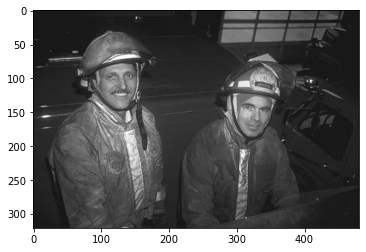

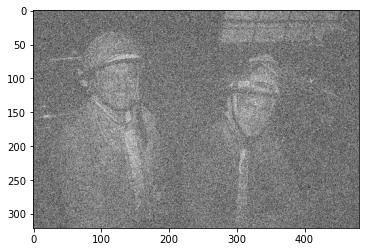

loss: 0.089752  [    0/  199]


In [ ]:

torch.manual_seed(14638)
transform_= transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.,0.3)
])
train_set = BSDSDataset(csv_file='../BSDS_train.csv', root_dir = 'C:/Users/Manuel/BSDS300-images/BSDS300/images/train_gray',
                      transform = transform_)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size =4, shuffle = True)


test_set = BSDSDataset(csv_file='../BSDS_test.csv', root_dir = 'C:/Users/Manuel/BSDS300-images/BSDS300/images/test_gray',
                      transform = transform_)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size =4, shuffle = True)

model = Aniso_MLP_()
#model.to('cuda')
torch.autograd.set_detect_anomaly(True)
learning_rate = 0.01
epochs = 10
begin = time.time()
loss_l2 = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
for t in range(epochs):
    #print(list(model.parameters()))
    #for param in model.parameters():
    #    print(param.data)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_l2, optimizer, t)
    time1 = time.time()
    print(time1 -begin)
    test_loop(test_loader, model, loss_l2)
    time2 = time.time()
    print(time2-begin)
end = time.time()

print(end-begin)

In [ ]:
img_ = Image.open('../cameraman.tif')
print(img_.size)
print(np.max(np.array(img_)))
img = sp_noise(img_,0.01)
begin = time.time()
img.show()
img_diff = Image.fromarray(np.uint8(Perona_Malik(img, 50, 0.2, 40, 1)))
end = time.time()
print(end-begin)
img_diff.show()

In [ ]:
img = Image.open('C:/Users/Manuel/BSDS300-images/BSDS300/images/train/161062.jpg')
#img.show()
gimg = ImageOps.grayscale(img)
gimg.show()
begin = time.time()
img_diff = Image.fromarray(np.uint8(Perona_Malik(gimg, 40, 0.25, 10, 0)))
end = time.time()
print(end-begin)
img_diff.show()

In [ ]:
img_ = Image.open('C:/Users/Manuel/MRI/brain2.png')
print(img_.size)
print(np.max(np.array(img_)))
img = sp_noise(img_,0.01)
img.show()
begin = time.time()
img_diff = Image.fromarray(np.uint8(Perona_Malik(img, 110, 0.2, 10,1)))
end = time.time()
print(end-begin)
img_diff.show()

In [25]:
img = Image.open('C:/Users/Manuel/BSDS300-images/BSDS300/images/train_gray/1.jpg')
img = AddGaussianNoise(img)
#torchvision.transforms.ToTensor(np.array(img))
print(img)

AddGaussianNoise(mean=<PIL.JpegImagePlugin.JpegImageFile image mode=L size=481x321 at 0x1B547878448>, std=1.0)


In [59]:

    
class PeronaMalik(nn.Module):
    def get_exp_diffusion_coefficient(self, k):
        return torch.exp(-torch.pow(self.gradients/k, 2) / self.diffusion_rate_2)

    def get_inv_diffusion_coefficient(self, k):
        return torch.pow(self.gradient_magnitude / (k +self.diffusion_rate_2) + 1, -1)

    def pick_coefficient(self, coefficient, k):
        # pick the method which will calculate the diffusion speed
        if coefficient == 'exp':
            self.coefficient = self.get_exp_diffusion_coefficient(k)
        elif coefficient == "inv":
            self.coefficient = self.get_inv_diffusion_coefficient(k)

    def get_conv_diffusion(self, image, padded_image):
        # experimental, doesn't work well
        return image * F.tanh(F.conv2d(1-padded_image, self.conv1_params))

    def init_weights(self, layer):
        nn.init.orthogonal(layer.weight)
        nn.init.constant(layer.bias, 0.0)

    def __init__(self, size, diffusion_rate, delta_t, coefficient='exp', learn_operator=False):
        super(PeronaMalik, self).__init__()
        self.flatten = nn.Flatten(1,3)
        self.layers = nn.Sequential(
        nn.Linear(481*321, 4),
        nn.ReLU(),
        #nn.Linear(256,64),
        #nn.ReLU(),
        #nn.Linear(64,16),
        #nn.ReLU(),
        #nn.Linear(32,4),
        #nn.ReLU(),
        #nn.Linear(8,4),
        #nn.ReLU(),
        nn.Linear(4,1)
        )
        self.gradients = None
        self.delta_t = delta_t
        self.gradient_magnitude = None

        # allow learning parameters using requires_grad=True
        self.diffusion_rate_2 = scalar_to_parameter(diffusion_rate ** 2, size, requires_grad=False)
        self.conv1_params = make_operator('laplace', requires_grad=True)

        self.laplace = make_operator('laplace', requires_grad=True)
        self.scharr_x = make_operator('scharr_x')
        self.scharr_y = make_operator('scharr_y')

        self.coefficient = coefficient
        #self.pick_coefficient(coefficient)

    def forward(self, image):
        z = self.flatten(image)
        k = self.layers(z)
        # ReflectionPad2d for the image boundaries instead of padding=1
        self.pick_coefficient(coefficient, k)
        padded_image = nn.ReflectionPad2d(1)(image)
        self.gradients = F.conv2d(padded_image, self.laplace)
        if self.coefficient == 'inv':
            grad_x = F.conv2d(padded_image, self.scharr_x)
            grad_y = F.conv2d(padded_image, self.scharr_y)
            self.gradient_magnitude = torch.sqrt(torch.pow(grad_x, k) + torch.pow(grad_y, k))

        #if self.coefficient is None:
        #    diffusion = self.gradients * torch.pow(
        #         torch.abs(self.get_conv_diffusion(image, padded_image)) / self.diffusion_rate_2 + 1, -1)
        for i in range(100):
            padded_image = nn.ReflectionPad2d(1)(image)
            self.gradients = F.conv2d(padded_image, self.laplace)
            diffusion = self.gradients * coeff()
            image = image + diffusion * self.delta_t

        return torch.clamp(image, min=0, max=1.0)

tensor([1, 2, 3])
